### Importing Packages

In [1]:
pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 121kB/s 
     |████████████████████████████████| 450kB 47.4MB/s 
     |████████████████████████████████| 3.8MB 45.8MB/s 
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [2]:
pip install tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 42kB/s 


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [0]:
import math

In [0]:
import itertools

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

### Custom Defined Functions

In [0]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

#### Setting TF.Keras backend and TF.Session to be same for later conversion into SavedModel format

In [0]:
tf.keras.backend.set_session = tf.compat.v1.Session()

### Defining Directory for dataset

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
base_dir = '/content/drive/My Drive/FYP/DATA/' 
train_dir = os.path.join(base_dir, 'train') 
validation_dir = os.path.join(base_dir, 'val')

### Setting up batch size, epochs and image size to be resized into

In [0]:
batch_size = 100
epochs = 100
IMG_SHAPE = 224 

### Downloading the pre-trained model

In [0]:
pre_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224,224,3), alpha=1.0,  include_top=False, weights='imagenet')

### Setting the layers of pre-trained model to be non trainable for transfer learning

In [0]:
for layer in pre_model.layers:
    layer.trainable = False

### Setting up Data Generators

In [0]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [35]:
train_data_gen = train_image_generator.flow_from_directory(
                                                batch_size=batch_size, 
                                                directory=train_dir, 
                                                shuffle=True, 
                                                class_mode='categorical',
                                                target_size=(IMG_SHAPE,IMG_SHAPE))

Found 10741 images belonging to 6 classes.


In [36]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=50, 
                                                              directory=validation_dir, 
                                                              class_mode='categorical',
                                                              target_size=(IMG_SHAPE,IMG_SHAPE),shuffle=False)

Found 3637 images belonging to 6 classes.


In [0]:
sample_training_images, _ = next(train_data_gen) 

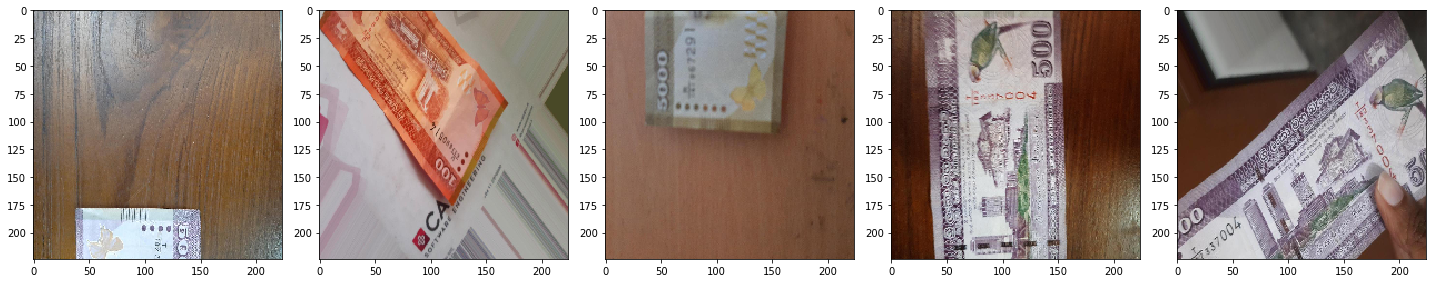

In [38]:
plotImages(sample_training_images[:5])

### Constructing the model

In [0]:
model_fine = tf.keras.models.Sequential()

In [0]:
model_fine.add(pre_model)

In [0]:
model_fine.add(tf.keras.layers.Flatten())

In [0]:
model_fine.add(tf.keras.layers.Dense(64, activation='relu'))
model_fine.add(tf.keras.layers.Dropout(0.4))
model_fine.add(tf.keras.layers.Dense(32, activation='relu'))

In [0]:
model_fine.add(tf.keras.layers.Dense(6, activation='softmax'))

In [44]:
model_fine.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4014144   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 198       
Total params: 6,274,406
Trainable params: 4,016,422
Non-trainable params: 2,257,984
____________________________________

### Compiling the model

In [0]:
model_fine.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

### Training process

In [48]:
history = model_fine.fit_generator(train_data_gen, validation_data=val_data_gen, epochs=50, steps_per_epoch=20, validation_steps=20)

Epoch 1/50
20/20 [==============================] - 87s 4s/step - loss: 1.9856 - categorical_accuracy: 0.1900 - val_loss: 1.8158 - val_categorical_accuracy: 0.2070
Epoch 2/50
20/20 [==============================] - 62s 3s/step - loss: 1.8266 - categorical_accuracy: 0.2335 - val_loss: 1.7263 - val_categorical_accuracy: 0.2940
Epoch 3/50
20/20 [==============================] - 66s 3s/step - loss: 1.7846 - categorical_accuracy: 0.2524 - val_loss: 1.7121 - val_categorical_accuracy: 0.2860
Epoch 4/50
20/20 [==============================] - 66s 3s/step - loss: 1.7028 - categorical_accuracy: 0.2870 - val_loss: 1.6320 - val_categorical_accuracy: 0.3630
Epoch 5/50
20/20 [==============================] - 62s 3s/step - loss: 1.6691 - categorical_accuracy: 0.3010 - val_loss: 1.5835 - val_categorical_accuracy: 0.3990
Epoch 6/50
20/20 [==============================] - 71s 4s/step - loss: 1.5879 - categorical_accuracy: 0.3385 - val_loss: 1.5781 - val_categorical_accuracy: 0.4130
Epoch 7/50
20/20

### Model evaluated on validation set

In [49]:
model_fine.evaluate_generator(val_data_gen)

[1.3829545437881392, 0.52020895]

### Plotting the training process

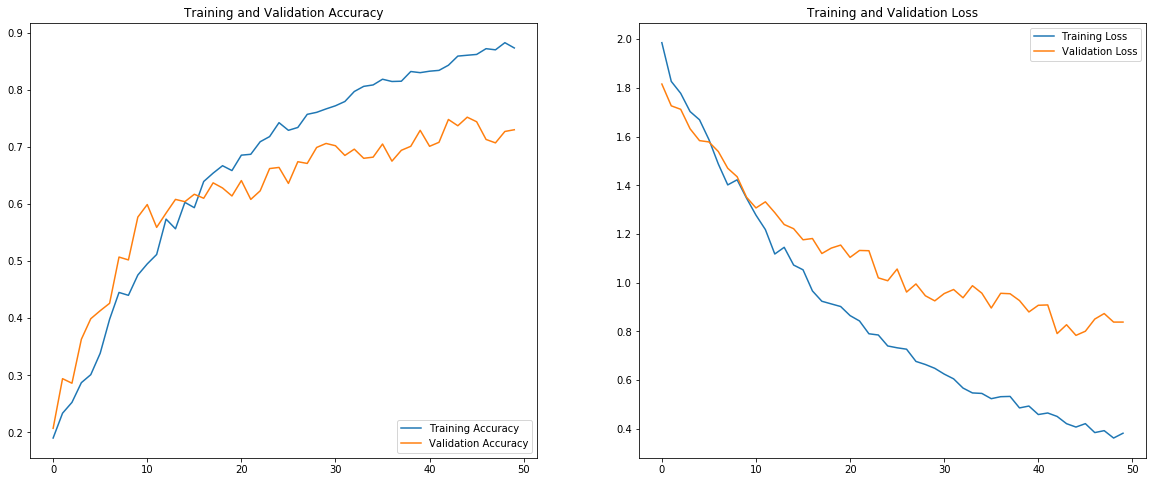

In [50]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
model_fine.save("CashKeras-50-transfer-epoch-drpt-03-lr0001.h5")

In [52]:
pre_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

### Setting the pre-trained model layers from block_15_add to be trainable for finetuning

In [0]:
position_layer = pre_model.get_layer('block_15_add')

In [0]:
for layer in pre_model.layers:
  layer.trainable = True

In [0]:
all_layers = pre_model.layers
for i in range(pre_model.layers.index(position_layer)):
    all_layers[i].trainable = False

In [0]:
model_fine.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [57]:
model_fine.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4014144   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 198       
Total params: 6,274,406
Trainable params: 4,902,502
Non-trainable params: 1,371,904
____________________________________

In [58]:
history = model_fine.fit_generator(train_data_gen, validation_data=val_data_gen, epochs=50, steps_per_epoch=20, validation_steps=20)

Epoch 1/50
20/20 [==============================] - 69s 3s/step - loss: 0.3586 - categorical_accuracy: 0.8715 - val_loss: 0.8440 - val_categorical_accuracy: 0.7330
Epoch 2/50
20/20 [==============================] - 59s 3s/step - loss: 0.3403 - categorical_accuracy: 0.8885 - val_loss: 0.8787 - val_categorical_accuracy: 0.7140
Epoch 3/50
20/20 [==============================] - 52s 3s/step - loss: 0.3325 - categorical_accuracy: 0.8975 - val_loss: 0.8570 - val_categorical_accuracy: 0.7160
Epoch 4/50
20/20 [==============================] - 58s 3s/step - loss: 0.3175 - categorical_accuracy: 0.8913 - val_loss: 0.8726 - val_categorical_accuracy: 0.7100
Epoch 5/50
20/20 [==============================] - 57s 3s/step - loss: 0.3246 - categorical_accuracy: 0.8880 - val_loss: 0.8845 - val_categorical_accuracy: 0.7100
Epoch 6/50
20/20 [==============================] - 57s 3s/step - loss: 0.2962 - categorical_accuracy: 0.9055 - val_loss: 0.8694 - val_categorical_accuracy: 0.7190
Epoch 7/50
20/20

In [0]:
model_fine.evaluate_generator(val_data_gen)

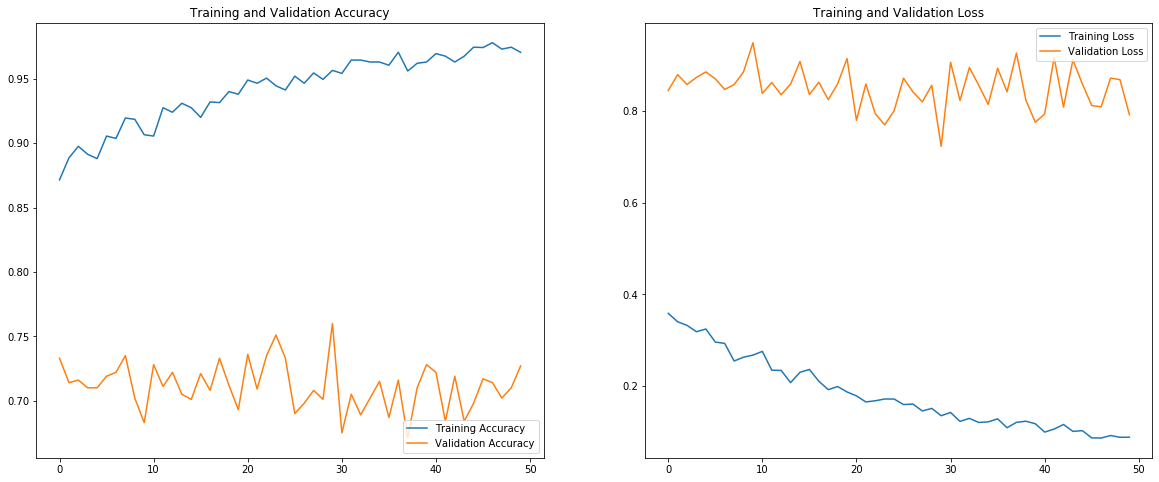

In [60]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
model_fine.save("CashKeras-50-finetune-epoch-drpt-03-lr0001.h5")

### Plotting the confusion matrix for classification evaluation

In [0]:
Y_pred = model_fine.predict_generator(val_data_gen)

In [0]:
y_pred = np.argmax(Y_pred, axis=1)

In [68]:
y_pred.shape

(3637,)

In [67]:
print('Confusion Matrix')
print(confusion_matrix(val_data_gen.classes, y_pred))

Confusion Matrix
[[525  12   0  45  14   9]
 [ 76 345   2 134  77  37]
 [ 79  42  78 325  41  17]
 [  9   2   1 563   5  17]
 [111  23   1 141 253  61]
 [ 22   5   0 246   6 313]]


In [0]:
cm = confusion_matrix(val_data_gen.classes, y_pred)

In [69]:
print('Classification Report')
target_names = ['fifty', 'fivehundred', 'fivethousand', 'hundred', 'thousand', 'twenty']
print(classification_report(val_data_gen.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       fifty       0.64      0.87      0.74       605
 fivehundred       0.80      0.51      0.63       671
fivethousand       0.95      0.13      0.23       582
     hundred       0.39      0.94      0.55       597
    thousand       0.64      0.43      0.51       590
      twenty       0.69      0.53      0.60       592

    accuracy                           0.57      3637
   macro avg       0.68      0.57      0.54      3637
weighted avg       0.69      0.57      0.55      3637



Confusion matrix, without normalization
[[525  12   0  45  14   9]
 [ 76 345   2 134  77  37]
 [ 79  42  78 325  41  17]
 [  9   2   1 563   5  17]
 [111  23   1 141 253  61]
 [ 22   5   0 246   6 313]]
Normalized confusion matrix
[[0.87 0.02 0.   0.07 0.02 0.01]
 [0.11 0.51 0.   0.2  0.11 0.06]
 [0.14 0.07 0.13 0.56 0.07 0.03]
 [0.02 0.   0.   0.94 0.01 0.03]
 [0.19 0.04 0.   0.24 0.43 0.1 ]
 [0.04 0.01 0.   0.42 0.01 0.53]]


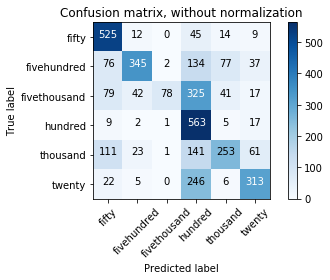

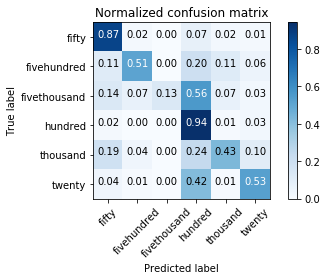

In [70]:
# Compute confusion matrix
cnf_matrix = cm
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [71]:
pre_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

### Setting the pre-trained model layers from block_13_expand to be trainable for finetuning

In [0]:
model_fine = tf.keras.loaded_model('')

In [0]:
position_layer = pre_model.get_layer('block_13_expand')

In [0]:
for layer in pre_model.layers:
  layer.trainable = True

In [0]:
all_layers = pre_model.layers
for i in range(pre_model.layers.index(position_layer)):
    all_layers[i].trainable = False

In [0]:
model_fine.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [76]:
model_fine.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4014144   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 198       
Total params: 6,274,406
Trainable params: 5,697,766
Non-trainable params: 576,640
______________________________________

In [77]:
history = model_fine.fit_generator(train_data_gen, validation_data=val_data_gen, epochs=50, steps_per_epoch=20, validation_steps=20)

Epoch 1/50
20/20 [==============================] - 71s 4s/step - loss: 0.0794 - categorical_accuracy: 0.9780 - val_loss: 0.8125 - val_categorical_accuracy: 0.7130
Epoch 2/50
20/20 [==============================] - 55s 3s/step - loss: 0.0896 - categorical_accuracy: 0.9753 - val_loss: 0.8262 - val_categorical_accuracy: 0.7110
Epoch 3/50
20/20 [==============================] - 55s 3s/step - loss: 0.0801 - categorical_accuracy: 0.9740 - val_loss: 0.8461 - val_categorical_accuracy: 0.7050
Epoch 4/50
20/20 [==============================] - 59s 3s/step - loss: 0.0772 - categorical_accuracy: 0.9800 - val_loss: 0.8681 - val_categorical_accuracy: 0.6970
Epoch 5/50
20/20 [==============================] - 58s 3s/step - loss: 0.0768 - categorical_accuracy: 0.9765 - val_loss: 0.8806 - val_categorical_accuracy: 0.6930
Epoch 6/50
20/20 [==============================] - 51s 3s/step - loss: 0.0779 - categorical_accuracy: 0.9765 - val_loss: 0.8904 - val_categorical_accuracy: 0.6840
Epoch 7/50
20/20

In [0]:
model_fine.evaluate_generator(val_data_gen)

[1.1621633192247076, 0.787642472676696]

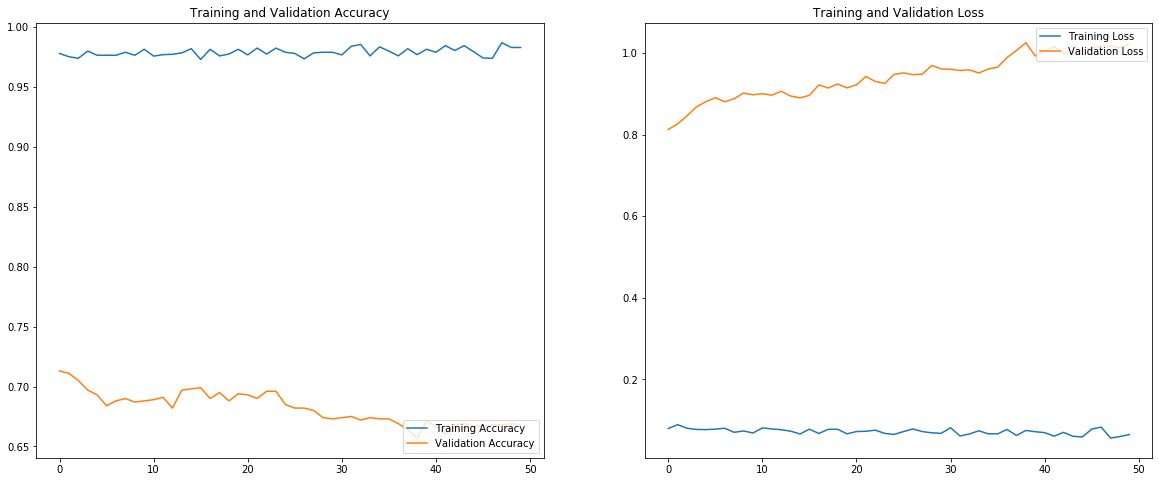

In [78]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
model_fine.save("CashKeras-50-finetune_2-epoch-drpt-03-lr0001.h5")

In [0]:
Y_pred = model_fine.predict_generator(val_data_gen)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(val_data_gen.classes, y_pred))



Confusion Matrix
[[504   2   3   1   3   1   1]
 [  1 500   0   0   0   0   0]
 [ 28  50 305  11  20  87   0]
 [ 99   3   1 348   5  40  25]
 [ 98  82  10   2 211  21  21]
 [ 12   5   2   0   0 482   0]
 [ 11  61   0   0   2   0 276]]


In [0]:
cm = confusion_matrix(val_data_gen.classes, y_pred)

In [0]:
print('Classification Report')
target_names = ['fifty', 'fivehundred', 'fivethousand', 'hundred', 'thousand', 'twenty']
print(classification_report(val_data_gen.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       fifty       0.67      0.98      0.79       515
        five       0.71      1.00      0.83       501
 fivehundred       0.95      0.61      0.74       501
     hundred       0.96      0.67      0.79       521
         ten       0.88      0.47      0.62       445
    thousand       0.76      0.96      0.85       501
      twenty       0.85      0.79      0.82       350

   micro avg       0.79      0.79      0.79      3334
   macro avg       0.83      0.78      0.78      3334
weighted avg       0.82      0.79      0.78      3334



Confusion matrix, without normalization
[[504   2   3   1   3   1   1]
 [  1 500   0   0   0   0   0]
 [ 28  50 305  11  20  87   0]
 [ 99   3   1 348   5  40  25]
 [ 98  82  10   2 211  21  21]
 [ 12   5   2   0   0 482   0]
 [ 11  61   0   0   2   0 276]]
Normalized confusion matrix
[[0.98 0.   0.01 0.   0.01 0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.06 0.1  0.61 0.02 0.04 0.17 0.  ]
 [0.19 0.01 0.   0.67 0.01 0.08 0.05]
 [0.22 0.18 0.02 0.   0.47 0.05 0.05]
 [0.02 0.01 0.   0.   0.   0.96 0.  ]
 [0.03 0.17 0.   0.   0.01 0.   0.79]]


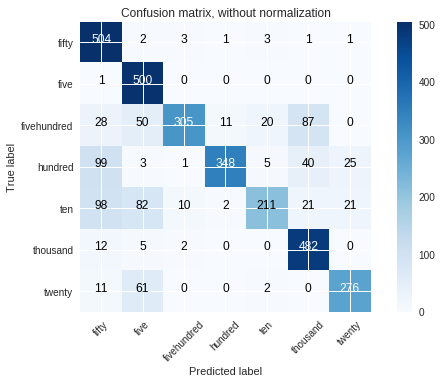

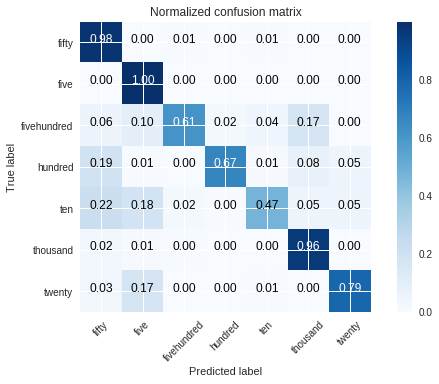

In [0]:
# Compute confusion matrix
cnf_matrix = cm
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [0]:
pre_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

### Setting all layers of the pre-trained model to be trainable

In [0]:
for layer in pre_model.layers:
  layer.trainable = True

In [0]:
model_fine.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0000001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [0]:
model_fine.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4014144   
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 231       
Total params: 6,274,439
Trainable params: 6,240,327
Non-trainable params: 34,112
_____________________________________________________________

In [0]:
history = model_fine.fit_generator(train_data_gen, validation_data=val_data_gen, epochs=50, steps_per_epoch=20, validation_steps=20)

Epoch 1/50
20/20 [==============================] - 75s 4s/step - loss: 0.0246 - categorical_accuracy: 0.9895 - val_loss: 0.0311 - val_categorical_accuracy: 0.9850
Epoch 2/50
20/20 [==============================] - 57s 3s/step - loss: 0.0320 - categorical_accuracy: 0.9870 - val_loss: 0.0298 - val_categorical_accuracy: 0.9870
Epoch 3/50
20/20 [==============================] - 58s 3s/step - loss: 0.0372 - categorical_accuracy: 0.9900 - val_loss: 0.0287 - val_categorical_accuracy: 0.9870
Epoch 4/50
20/20 [==============================] - 58s 3s/step - loss: 0.0328 - categorical_accuracy: 0.9895 - val_loss: 0.0277 - val_categorical_accuracy: 0.9870
Epoch 5/50
20/20 [==============================] - 57s 3s/step - loss: 0.0456 - categorical_accuracy: 0.9874 - val_loss: 0.0266 - val_categorical_accuracy: 0.9890
Epoch 6/50
20/20 [==============================] - 56s 3s/step - loss: 0.0393 - categorical_accuracy: 0.9880 - val_loss: 0.0258 - val_categorical_accuracy: 0.9900
Epoch 7/50
20/20

In [0]:
model_fine.evaluate_generator(val_data_gen)

[0.3818444494975334, 0.9196160777858009]

In [0]:
model_fine.save("CashKeras-50-finetune_all-epoch-drpt-03-lr0000001.h5")

In [0]:
Y_pred = model_fine.predict_generator(val_data_gen)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(val_data_gen.classes, y_pred))



Confusion Matrix
[[511   0   1   3   0   0   0]
 [  0 501   0   0   0   0   0]
 [  0   9 465   0   0  27   0]
 [ 47   0   1 421   4  42   6]
 [ 46   6  19   6 336  25   7]
 [  1   1   1   0   0 497   1]
 [  3   6   0   3   2   1 335]]


In [0]:
cm = confusion_matrix(val_data_gen.classes, y_pred)

In [0]:
print('Classification Report')
target_names = ['fifty', 'fivehundred', 'fivethousand', 'hundred', 'thousand', 'twenty']
print(classification_report(val_data_gen.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       fifty       0.84      0.99      0.91       515
        five       0.96      1.00      0.98       501
 fivehundred       0.95      0.93      0.94       501
     hundred       0.97      0.81      0.88       521
         ten       0.98      0.76      0.85       445
    thousand       0.84      0.99      0.91       501
      twenty       0.96      0.96      0.96       350

   micro avg       0.92      0.92      0.92      3334
   macro avg       0.93      0.92      0.92      3334
weighted avg       0.93      0.92      0.92      3334



Confusion matrix, without normalization
[[511   0   1   3   0   0   0]
 [  0 501   0   0   0   0   0]
 [  0   9 465   0   0  27   0]
 [ 47   0   1 421   4  42   6]
 [ 46   6  19   6 336  25   7]
 [  1   1   1   0   0 497   1]
 [  3   6   0   3   2   1 335]]
Normalized confusion matrix
[[0.99 0.   0.   0.01 0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.02 0.93 0.   0.   0.05 0.  ]
 [0.09 0.   0.   0.81 0.01 0.08 0.01]
 [0.1  0.01 0.04 0.01 0.76 0.06 0.02]
 [0.   0.   0.   0.   0.   0.99 0.  ]
 [0.01 0.02 0.   0.01 0.01 0.   0.96]]


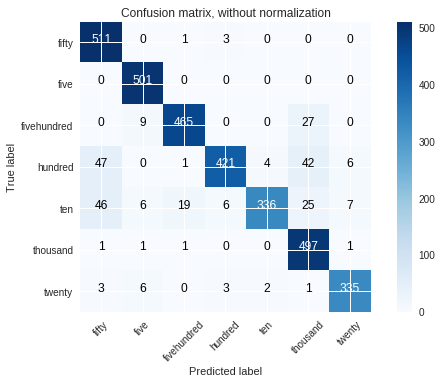

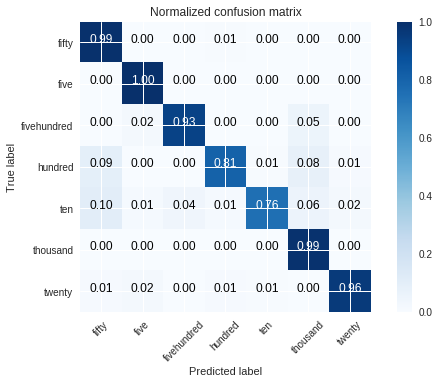

In [0]:
# Compute confusion matrix
cnf_matrix = cm
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()